# Machine Learning & The Titanic
https://www.kaggle.com/c/titanic/overview

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn import preprocessing

## Data Analysis

In [14]:
# Read the data
X_full = pd.read_csv("train.csv", index_col='PassengerId')
X_test_full = pd.read_csv('test.csv', index_col='PassengerId')
print(X_full.info(), "\n")
print(X_test_full.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory us

In [168]:
# Remove rows with missing target, separate target from predictors
# X_full.dropna(axis=0, subset=['Survived'], inplace=True)
y = X_full.Survived
# X_full.drop(['Survived'], axis=1, inplace=True)

print("training data nrows: ", len(X_full), "\n", "test data nrows: ", len(X_test_full))
print("deafault features: ", X_full.columns)
print("\n")
print("Column Data Types: ")
for col in X_full:
    print(col, X_full[col].dtype)
print("\n")
print("Training Data Missing Value Proportions: ")
for col in X_full:
    print(col, X_full[col].isna().sum()/len(X_full[col]))
print("\n", "Test Data Missing Value Proportions: ")
for col in X_test_full:
    print(col, X_test_full[col].isna().sum()/len(X_test_full[col]))
    
# Select categorical columns
initial_categorical_cols = [col for col in X_full.columns if
                    X_full[col].nunique() < 10 and
                    X_full[col].isna().sum()/len(X_full[col]) < 0.50 and 
                    X_full[col].dtype in ['object']]

# Select numerical columns
initial_numerical_cols = [col for col in X_full.columns if 
                X_full[col].isna().sum()/len(X_full[col]) < 0.50 and 
                X_full[col].dtype in ['int64', 'float64']]

features = initial_categorical_cols + initial_numerical_cols
features.remove("Survived")

age_bins = [0, 5, 10, 20, 30, 40, 60, 80]
X_full["binned_age"] = pd.cut(X_full["Age"], age_bins)
X_test_full["binned_age"] = pd.cut(X_test_full["Age"], age_bins)
features.append("binned_age")

fare_bins = [0, 10, 20, 30, 50, 100, 250, 500]
X_full["binned_fare"] = pd.cut(X_full["Fare"], fare_bins)
X_test_full["binned_fare"] = pd.cut(X_test_full["Fare"], fare_bins)
features.append("binned_fare")

training data nrows:  891 
 test data nrows:  418
deafault features:  Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'binned age', 'binned fare', 'binned_age',
       'binned_fare', 'Title', 'Family_Size'],
      dtype='object')


Column Data Types: 
Survived int64
Pclass int64
Name object
Sex object
Age float64
SibSp int64
Parch int64
Ticket object
Fare float64
Cabin object
Embarked object
binned age category
binned fare category
binned_age category
binned_fare category
Title object
Family_Size int64


Training Data Missing Value Proportions: 
Survived 0.0
Pclass 0.0
Name 0.0
Sex 0.0
Age 0.19865319865319866
SibSp 0.0
Parch 0.0
Ticket 0.0
Fare 0.0
Cabin 0.7710437710437711
Embarked 0.002244668911335578
binned age 0.19865319865319866
binned fare 0.020202020202020204
binned_age 0.19865319865319866
binned_fare 0.020202020202020204
Title 0.0
Family_Size 0.0

 Test Data Missing Value Proportions: 
Pclass 0.0
Name 0.0
Sex 0.0

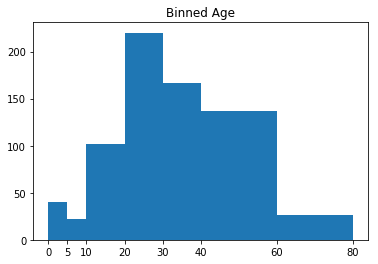

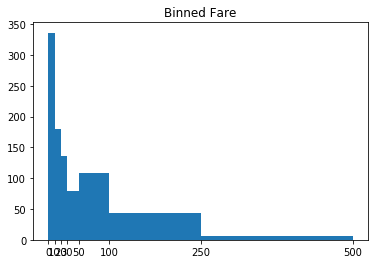

In [128]:
plt.hist(final_X.Age, bins = age_bins)
plt.xticks(age_bins)
plt.title("Binned Age")
plt.show()

plt.hist(final_X.Fare, bins = fare_bins)
plt.xticks(fare_bins)
plt.title("Binned Fare")
plt.show()

In [159]:
X_full['Title'] = X_full.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
X_test_full['Title'] = X_test_full.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

X_full['Title'] = X_full['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
X_full['Title'] = X_full['Title'].replace('Mlle', 'Miss')
X_full['Title'] = X_full['Title'].replace('Ms', 'Miss')
X_full['Title'] = X_full['Title'].replace('Mme', 'Mrs')

X_test_full['Title'] = X_test_full['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
X_test_full['Title'] = X_test_full['Title'].replace('Mlle', 'Miss')
X_test_full['Title'] = X_test_full['Title'].replace('Ms', 'Miss')
X_test_full['Title'] = X_test_full['Title'].replace('Mme', 'Mrs')
    
features.append("Title")

In [162]:
X_full["Family_Size"] = X_full["SibSp"] + X_full["Parch"] + 1
X_test_full["Family_Size"] = X_test_full["SibSp"] + X_test_full["Parch"] + 1

features.append("Family_Size")

In [163]:
X_temp = X_full.copy()
for col in X_full[features]:
    if X_full[col].nunique() < 10:
        print(X_temp[[col, 'Survived']].groupby([col], as_index=False).mean().sort_values(by='Survived', ascending=False), "\n")

      Sex  Survived
0  female  0.742038
1    male  0.188908 

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957 

    Title  Survived
3     Mrs  0.793651
1    Miss  0.702703
0  Master  0.575000
4    Rare  0.347826
2      Mr  0.156673 

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363 

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000 

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000 

  binned_age  Survived
0     (0, 5]  0.704545
4   (30, 40]  0.445161
5   (40, 60]  0.390625
2   (10, 20]  0.382609
3   (20, 30]  0.365217
1    (5, 10]  0.350000
6   (60, 80]  0.227273 

  binned_fare  Survived
5  (100, 250]  0.727273
6  (250, 500]  0.666667
4   (50, 100]  0.654206
2    (20, 30]  0.443662
1    (10, 20]  0.424581
3    (30, 

In [169]:
final_features = ["Sex", "Embarked", "Pclass", "Title", "Family_Size", "Fare", "Age"]
X_final = X_full[final_features]
X_test_final = X_test_full[final_features]

# Select categorical columns
categorical_cols = [col for col in X_final.columns if
                    X_final[col].nunique() < 10 and
                    X_final[col].isna().sum()/len(X_final[col]) < 0.50 and 
                    X_final[col].dtype in ['object']]

# Select numerical columns
numerical_cols = [col for col in X_final.columns if 
                X_final[col].isna().sum()/len(X_final[col]) < 0.50 and 
                X_final[col].dtype in ['int64', 'float64']]

print(categorical_cols, numerical_cols)

['Sex', 'Embarked', 'Title'] ['Pclass', 'Family_Size', 'Fare', 'Age']


## Pipeline, Random Forest, Cross-Validation Method

In [173]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Optimize n_estimators
def score_pipeline(n, optim_pre = preprocessor):
    optim_model = RandomForestClassifier(n_estimators = n, random_state=1)
    optim_pipeline = Pipeline(steps=[('preprocessor', optim_pre), ('model', optim_model)])
    optim_scores = -1 * cross_val_score(optim_pipeline, X_final, y,
                              cv=10,
                              scoring='neg_mean_absolute_error')
    return(optim_scores.mean())
score_list = []
n_est = range(1,100)
for i in range(len(n_est)):
    score_list.append(score_pipeline(n_est[i]))
best_n_estimators = n_est[np.where(score_list == np.amin(score_list))[0][0]]
print(best_n_estimators)

# define model
model = RandomForestClassifier(n_estimators = best_n_estimators, random_state=1)
# model =  XGBClassifier(n_estimators=500, learning_rate=0.05)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_final, y)

# test pipeline via cross validation
scores = -1 * cross_val_score(my_pipeline, X_final, y,
                              cv=10,
                              scoring='neg_mean_absolute_error')

# print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

# Preprocessing of validation data, get predictions
# preds = my_pipeline.predict(X_valid)
# print('MAE:', mean_absolute_error(y_valid, preds))

19
Average MAE score (across experiments):
0.18738196572466234


In [176]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test_final)

# output
output = pd.DataFrame({'PassengerId': X_test_final.index,
                      'Survived': preds_test})
print(output)
output.to_csv('submission.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         1
4            896         1
5            897         0
6            898         0
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         1
18           910         0
19           911         1
20           912         0
21           913         1
22           914         1
23           915         1
24           916         1
25           917         0
26           918         1
27           919         1
28           920         1
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284         1
3

## Manual Preprocessing, XGBoost, Single Validation Method

In [ ]:
# Break off validation set from training data
# X_train, X_valid, y_train, y_valid = train_test_split(final_X, y, random_state=1)

In [42]:
def numerical_transform(X_t = X_train[numerical_cols], X_v = X_valid[numerical_cols]):
    num_imputer = SimpleImputer(strategy = "median")
    imputed_X_train = pd.DataFrame(num_imputer.fit_transform(X_t))
    imputed_X_valid = pd.DataFrame(num_imputer.transform(X_v))
    imputed_X_train.columns = X_train[numerical_cols].columns
    imputed_X_valid.columns = X_valid[numerical_cols].columns
    return(imputed_X_train, imputed_X_valid)

def categorical_transform(X_t = X_train[categorical_cols], X_v = X_valid[categorical_cols]):
    cat_imputer = SimpleImputer(strategy = "most_frequent")
    cat_imputed_X_train = pd.DataFrame(cat_imputer.fit_transform(X_t))
    cat_imputed_X_valid = pd.DataFrame(cat_imputer.transform(X_v))
    cat_imputed_X_train.columns = X_train[categorical_cols].columns
    cat_imputed_X_valid.columns = X_valid[categorical_cols].columns
    
    genders = ["male", "female"]
    embark = ["S", "C", "Q"]
    cat_OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, categories = [genders, embark])
    cat_OH_train = pd.DataFrame(cat_OH_encoder.fit_transform(cat_imputed_X_train))
    cat_OH_valid = pd.DataFrame(cat_OH_encoder.transform(cat_imputed_X_valid))
    cat_OH_train.index = X_train[categorical_cols].index
    cat_OH_valid.index = X_valid[categorical_cols].index
    
    
    return(cat_OH_train, cat_OH_valid)

# num_imputer = SimpleImputer(strategy = "median")

# pd.num_imputer.fit_transform(X_train[numerical_cols])
X_train_a, X_valid_a = numerical_transform()
# X_train_a.sort_index(axis = 0)
# X_valid_a.sort_index(axis = 0)

X_train_b, X_valid_b = categorical_transform()
# X_train_b = X_train_b.sort_index(axis = 0)
# X_valid_b = X_valid_b.sort_index(axis = 0)

# merge a and b df's
# X_train_final = X_train_a.merge(X_train_b, how='inner', left_index=True, right_index=True)
# X_valid_final = X_valid_a.merge(X_valid_b, how='inner', left_index=True, right_index=True)
# print(X_train_final)


In [70]:
cat_imputer = SimpleImputer(strategy = "most_frequent")

a = X_train.copy()
b = a.Embarked
b = cat_imputer.fit_transform(np.array(b).reshape(1, -1))

a.Embarked = pd.DataFrame(b.reshape(-1, 1))
a

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
36,male,S,1,42.00,1,0,52.0000
47,male,S,3,NaN,1,0,15.5000
454,male,S,1,49.00,1,0,89.1042
292,female,S,1,19.00,1,0,91.0792
749,male,NaN,1,19.00,1,0,53.1000
42,female,S,2,27.00,1,0,21.0000
225,male,C,1,38.00,1,0,90.0000
341,male,S,2,2.00,1,1,26.0000
126,male,S,3,12.00,1,0,11.2417


In [77]:
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model_2.fit(X_train_final, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid_final, y_valid)], 
             verbose=False)

# Get predictions
predictions = my_model_2.predict(X_valid_final) # Your code here

# Calculate MAE
mae = mean_absolute_error(predictions, y_valid) # Your code here

# Uncomment to print MAE
print("Mean Absolute Error:" , mae)

[15:00:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBoostError: [15:00:24] src/objective/regression_obj.cu:65: Check failed: preds.Size() == info.labels_.Size() (506 vs. 668) : labels are not correctly providedpreds.size=506, label.size=668

## Outdated

In [ ]:
# # features to fit model off of
# features = ["Pclass", "SibSp", "Parch", "Age", "Sex", "Fare"]

# # model data
# x = training_data[features]
# y = training_data.Survived
# print(x)

In [ ]:
# # preproccessing data

# def score_dataset(X_train, X_valid, y_train, y_valid):
#     model = RandomForestRegressor(n_estimators=10, random_state=1)
#     model.fit(X_train, y_train)
#     preds = model.predict(X_valid)
#     return mean_absolute_error(y_valid, preds)

# train_x, val_x, train_y, val_y = train_test_split(x, y, random_state = 1)

# # accounting for categorical variables-------------------------------------------------------------------------
# split_object_cols = [col for col in train_x.columns if train_x[col].dtype == "object"]

# # Apply one-hot encoder to each column with categorical data
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_x[split_object_cols]))
# OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_x[split_object_cols]))

# # One-hot encoding removed index; put it back
# OH_cols_train.index = train_x.index
# OH_cols_valid.index = val_x.index

# # Remove categorical columns (will replace with one-hot encoding)
# num_X_train = train_x.drop(split_object_cols, axis=1)
# num_X_valid = val_x.drop(split_object_cols, axis=1)

# # Add one-hot encoded columns to numerical features
# OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
# OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# # accounting for missing values-----------------------------------------------------------------------------------
# my_imputer = SimpleImputer(strategy = "median")
# final_x_train = pd.DataFrame(my_imputer.fit_transform(OH_X_train))
# final_x_valid = pd.DataFrame(my_imputer.transform(OH_X_valid))

# score_dataset(final_x_train, final_x_valid, train_y, val_y)

In [ ]:
# # testing model

# def score_model(split_model, x_t=final_x_train, x_v=final_x_valid, y_t=train_y, y_v=val_y):
#     split_model.fit(x_t, y_t)
#     split_preds = split_model.predict(x_v)
#     return mean_absolute_error(y_v, split_preds)

# # find optimal number of estimators based of minimum mean absolute deviation of prediction from split data
# scores = []
# n_est = range(1,100)
# for i in range(len(n_est)):
#     scores.append(score_model(RandomForestClassifier(n_estimators = n_est[i], random_state=1)))
    
# best_n_estimators = n_est[np.where(scores == np.amin(scores))[0][0]]

# # define model, test validity
# model = RandomForestClassifier(n_estimators = best_n_estimators, random_state=1)
# score_model(model)

In [ ]:
# # actual model fit
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols = pd.DataFrame(OH_encoder.fit_transform(x[split_object_cols]))
# OH_cols.index = x.index
# num_X = x.drop(split_object_cols, axis=1)
# OH_X = pd.concat([num_X, OH_cols], axis=1)

# final_x = pd.DataFrame(my_imputer.transform(OH_X))

# model.fit(final_x, y)

In [ ]:
# # using model to make predictions off of test data
# test_data = pd.read_csv("test.csv")
# x_test = test_data[features]

# OH_encoder_test = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols_test = pd.DataFrame(OH_encoder_test.fit_transform(x_test[split_object_cols]))
# OH_cols_test.index = x_test.index
# num_X_test = x_test.drop(split_object_cols, axis=1)
# OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# final_x = pd.DataFrame(my_imputer.transform(OH_X_test))

# test_preds = model.predict(final_x)
# # print(test_preds)

In [ ]:
# # creating output file
# output = pd.DataFrame({'PassengerId': test_data.PassengerId,
#                       'Survived': test_preds})
# output.to_csv('submission.csv', index=False)